# Analysis with Proper Orthogonal Decomposition

Here we will use a classical method to obtained our reduced order model of the Kolmogorov flow based on Proper Orthogonal Decomposition.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import librairies

In [ ]:
import os
import numpy as np
import argparse
from numpy import linalg as LA
import matplotlib.pyplot as plt
import h5py

# 2. Read dataset

In [ ]:
hf = h5py.File('/content/drive/MyDrive/Kolmogorov_Re10_T20000_DT01.h5','r')
print(hf)
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
# if Nu ==2:
#     u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
hf.close()
print(u_all.shape)


# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)
# if Nu==2:
#     v_min = np.amin(u_all[:,:,:,1])
#     v_max = np.amax(u_all[:,:,:,1])
#     u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)

<HDF5 file "Kolmogorov_Re10_T20000_DT01.h5" (mode r)>
(4000, 24, 24, 1)


# 3. Compute POD modes

In [ ]:
Ntrain = 700
dim = u_all.shape

UU = np.reshape(u_all[:Ntrain,:],(Ntrain,dim[1]*dim[2]*dim[3]))

m = UU.shape[0]
C = np.matmul(np.transpose(UU),UU)/(m-1)

#solve eigenvalue problem
eig, phi = LA.eigh(C)

#Sort Eigenvalues and vectors
idx = eig.argsort()[::-1]
eig = eig[idx]
phi = phi[:, idx]

#project onto modes for temporal coefficients
a = np.matmul(UU,phi) # contains the "code" (modal coefficients)


phi_spat = np.reshape(phi,(dim[1],dim[2],dim[1]*dim[2])) # contains the spatial mode

print("check orthogonality")
print(np.matmul(np.transpose(phi),phi))

print("relative contribution of eigenvalues")
contrib = eig/np.sum(eig)

check orthogonality
[[ 1.00000000e+00  4.42354486e-17 -3.68628739e-18 ... -3.53883589e-16
   2.42861287e-16  7.97972799e-17]
 [ 4.42354486e-17  1.00000000e+00  1.38777878e-17 ...  5.20417043e-17
   1.51788304e-17  1.59160879e-16]
 [-3.68628739e-18  1.38777878e-17  1.00000000e+00 ...  1.56125113e-17
   0.00000000e+00  4.68375339e-17]
 ...
 [-3.53883589e-16  5.20417043e-17  1.56125113e-17 ...  1.00000000e+00
  -4.51028104e-17  3.85108612e-16]
 [ 2.42861287e-16  1.51788304e-17  0.00000000e+00 ... -4.51028104e-17
   1.00000000e+00 -5.20417043e-17]
 [ 7.97972799e-17  1.59160879e-16  4.68375339e-17 ...  3.85108612e-16
  -5.20417043e-17  1.00000000e+00]]
relative contribution of eigenvalues


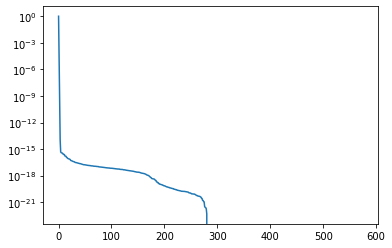

In [ ]:
%matplotlib inline
plt.figure()
plt.semilogy(contrib) # plot the contribution of each mode to the overall energy

# print("size of coefficients")
# print(a.shape)

# print("size of input")
# print(UU.shape)

# 4. Visualization of some modes and error computation

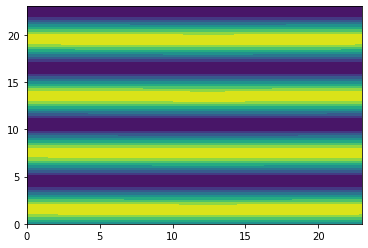

In [ ]:
imode = 0
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(phi_spat[:,:,imode])

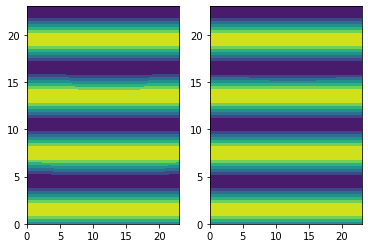

In [ ]:
# Visualization of modal reconstruction with truncated number of modes
isample = 50
nmodes = 1

# To reconstruct the field ("decode"), we just matrix-multiply the modal coefficients with the spatial modes
# but we do that for a truncated number of modes, instead of using the full modes
recons = np.matmul(a[:,:nmodes],np.transpose(phi[:,:nmodes]))


fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(np.reshape(recons[isample,:],(dim[1],dim[2])))
ax = fig.add_subplot(122)
ax.contourf(np.reshape(UU[isample,:],(dim[1],dim[2])))

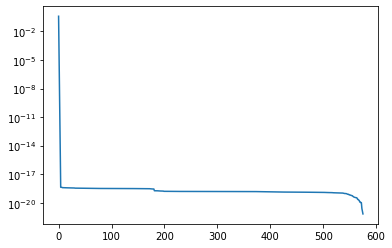

In [ ]:
# Mean reconstruction error for different number of retained modes
# We can compute the reconstruction of a varying number of modes and compute the error with our original data
err = np.zeros((dim[1]*dim[2]))
for i in range(dim[1]*dim[2]):
    recons = np.matmul(a[:,:i],np.transpose(phi[:,:i]))
    err[i] = np.mean(np.mean(np.square(UU - recons)))

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(err)

# 5. Projection of the validation data onto truncated mode and error assessment 

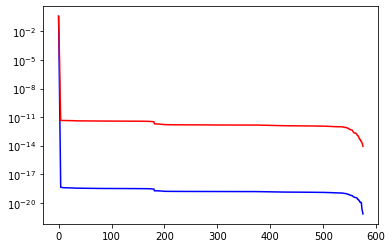

In [ ]:
UU_valid = np.reshape(u_all[Ntrain:,:],(dim[0]-Ntrain,dim[1]*dim[2]*dim[3]))
a_valid = np.matmul(UU_valid,phi)

# Mean reconstruction error for different number of retained modes
err_valid = np.zeros((dim[1]*dim[2]))
for i in range(dim[1]*dim[2]):
    recons = np.matmul(a_valid[:,:i],np.transpose(phi[:,:i]))
    err_valid[i] = np.mean(np.mean(np.square(UU_valid - recons)))

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(err,'b')
ax.semilogy(err_valid,'r')


6. POD errror for given number of nodes

In [ ]:
nmodes = 128

print(f'POD error for {nmodes} modes: {err_valid[nmodes]}')

POD error for 128 modes: 3.786259458763663e-12
